In [2]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [1]:
!pip install pykalman

     |████████████████████████████████| 235kB 5.9MB/s eta 0:00:01
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=de5f5b3fff670c705d87aa15676228c31ffca530ae83807a1993b7e2343113ce
  Stored in directory: /Users/hasegawataiga/Library/Caches/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
pip install statsmodels

     |████████████████████████████████| 10.5MB 9.5MB/s eta 0:00:01    |███████████████████████▋        | 7.7MB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 235kB 5.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from pykalman import KalmanFilter

In [6]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')

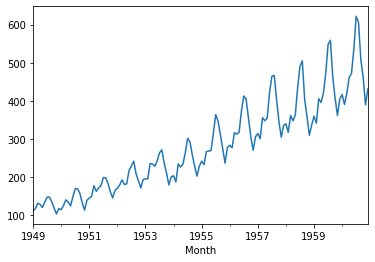

In [7]:
y.plot()

In [8]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
  
    # 各行列のトレンド成分に対するブロック行列を構築
    G[0,0] = 1
    H[0,0] = 1
    
    # トレンドモデルの推移行列の構築
    # 非定常過程でも対応できる推移行列を構築 
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [9]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs)

In [10]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [11]:
# 前半120時点を学習データに121時点以降のデータを検証用に使用
n_train = 120
train, test = y.values[:n_train], y.values[n_train:]

In [9]:
# filtered_state_means, filtered_state_covs = kf.filter(train)
# pred_o = filtered_state_means.dot(H.T)

In [12]:
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)

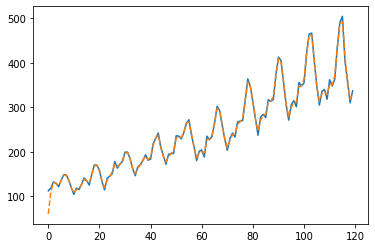

In [13]:
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

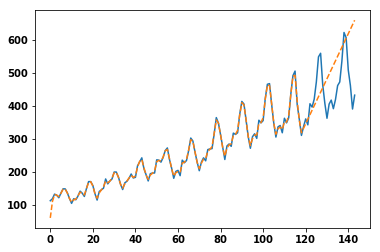

In [12]:
plt.plot(y.values, label="observation")

# 長期予測格納用のベクトルを用意（値は全て入れ替わるため0で初期化しなくてよい）
pred_y = np.empty(len(test))

# 現在の状態と分散共分散行列を取得
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    # filter_updateは観測値を入力しなければ1期先予測のみを実行する
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
# np.hstackはnp.concatenateでもよい
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")